# Adaptive fingerprinting

This notebook investigates adaptive approaches for fingeprinting as a preventive defense strategy against targeted attacks.

In [1]:
import os
os.chdir("C:\\Users\\tsarcevic\\PycharmProjects\\fingerprinting-toolbox")
import warnings
warnings.filterwarnings('ignore')

In [8]:
import pickle
import numpy as np
import pandas as pd
import collections
import random

from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif as MIC

from scipy.stats import chi2
from imblearn.under_sampling import *

from datasets import GermanCredit
from attacks import *
from parameter_guidelines.guidelines import *
from scheme import *

## 1. Defense against targeted vertical subset attack

The experiment:
- find most important feature using some other strategy than the attacker (attacker's strategy: impurity-based feature importances); verify that the features are different
- embed the fingerprint in those
- feature selection by the attacker (done in other notebook)
- find the strenght that removes the fingerprint i.e.
    - attack with 1 removed
    - detection: successful? increase atrength by 1 and repeat
    - until detection unsuccessful
- this is robustness
- record utility of attacked data


- also record utility of fingerprinted from the beginning of the experiment

In [3]:
# experiment parameters
fpaatr = [4,8,12,16,20]
gammae = gammae = [1, 2, 3, 4, 5, 10, 18]  
    #gammae = [1.11, 1.25, 1.43, 1.67, 2.5]

In [4]:
# original data
data = GermanCredit()
X = data.preprocessed().drop('target', axis=1)
y = data.preprocessed()['target']
X.columns

Index(['checking_account', 'duration', 'credit_hist', 'purpose',
       'credit_amount', 'savings', 'employment_since', 'installment_rate',
       'sex_status', 'debtors', 'residence_since', 'property', 'age',
       'installment_other', 'housing', 'existing_credits', 'job',
       'liable_people', 'tel', 'foreign'],
      dtype='object')

In [8]:
# defender features
mi_scores = MIC(X,y)
print(mi_scores)

[0.06636297 0.03858708 0.01779664 0.01836916 0.0130141  0.00093451
 0.00868565 0.0082244  0.         0.00291085 0.         0.00625847
 0.01926637 0.         0.         0.03353724 0.01272182 0.
 0.02091543 0.01358897]


In [9]:
feature_importances_defense = dict(zip(X.columns, mi_scores))
dict(sorted(feature_importances_defense.items(), key=lambda item: -item[1]))

{'checking_account': 0.06636297191355123,
 'duration': 0.03858707701759445,
 'existing_credits': 0.03353723622343141,
 'tel': 0.020915425114115038,
 'age': 0.01926636838883211,
 'purpose': 0.01836916385547216,
 'credit_hist': 0.01779663751766969,
 'foreign': 0.013588969859152478,
 'credit_amount': 0.01301410077683185,
 'job': 0.012721819425923764,
 'employment_since': 0.00868565151517009,
 'installment_rate': 0.00822439736929459,
 'property': 0.006258470591618215,
 'debtors': 0.0029108537588464767,
 'savings': 0.000934514238938533,
 'sex_status': 0.0,
 'residence_since': 0.0,
 'installment_other': 0.0,
 'housing': 0.0,
 'liable_people': 0.0}

In [5]:
# attacker's features
feature_importances_attack = {'checking_account': 0.21514958469895673,
 'duration': 0.13044392484665898,
 'credit_hist': 0.08577361202438204,
 'purpose': 0.037542360031586446,
 'credit_amount': 0.17261276703874145,
 'savings': 0.04680897088703411,
 'employment_since': 0.03161875938692153,
 'installment_rate': 0.022951027357519246,
 'sex_status': 0.006977414324585844,
 'debtors': 0.01549920743767321,
 'residence_since': 0.006314167794645683,
 'property': 0.04161068704700113,
 'age': 0.09356728372727559,
 'installment_other': 0.04487824182105095,
 'housing': 0.010520190596630376,
 'existing_credits': 0.013612419726994892,
 'job': 0.008691845710110693,
 'liable_people': 0.010437271782373785,
 'tel': 0.003110805448656495,
 'foreign': 0.0018794583112007593}
#dict(sorted(feature_importances_attack.items(), key=lambda item: -item[1]))

In [116]:
# embedding the fingerpting - test case
fplen = 8
numbuyers = 100
column_subset = 20
gamma = 18
xi=1
uid=1
SK=0

scheme = Universal(gamma=gamma, xi=xi, fingerprint_bit_length=fplen, number_of_recipients=100)
exclude=['debtors','residence_since','age','tel']
fingerprinted_data = scheme.insertion(data, recipient_id=uid, secret_key=SK, exclude=exclude)

Start insertion algorithm...
	gamma: 18
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 0

Generated fingerprint for recipient 1: 01011111
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'credit_hist', 'purpose',
       'credit_amount', 'savings', 'employment_since', 'installment_rate',
       'sex_status', 'property', 'installment_other', 'housing',
       'existing_credits', 'job', 'liable_people', 'foreign'],
      dtype='object')
Fingerprint inserted.
	marked tuples: ~6.7%
	single fingerprint bit embedded 8 times
Time: <1 sec.


In [9]:
fingerprinted_data.dataframe

,Id,checking_account,duration,credit_hist,purpose,credit_amount,savings,employment_since,installment_rate,sex_status,...,property,age,installment_other,housing,existing_credits,job,liable_people,tel,foreign,target
0,0,A11,6,A34,A43,1169,A64,A75,4,A93,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,1,A12,48,A32,A43,5950,A61,A73,2,A92,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,2,A14,12,A34,A46,2096,A61,A74,2,A93,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,3,A11,42,A32,A42,7882,A61,A74,2,A93,...,A123,45,A143,A153,1,A173,2,A191,A201,1
4,4,A11,24,A33,A40,4870,A61,A73,3,A93,...,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,A14,12,A32,A42,1736,A61,A74,3,A92,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,996,A11,30,A32,A41,3857,A61,A73,4,A91,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,997,A14,12,A32,A43,804,A61,A75,4,A93,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,998,A11,45,A32,A43,1845,A61,A73,4,A93,...,A122,23,A143,A153,1,A173,1,A192,A201,2


In [119]:
# test detection
suspect = scheme.detection(fingerprinted_data, secret_key=SK, primary_key_attribute='Id', target_attribute='target',
                          exclude=exclude, original_attributes=pd.Series(data=X.columns.to_list()))

Start detection algorithm...
	gamma: 18
	fingerprint length: 8
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'credit_hist', 'purpose',
       'credit_amount', 'savings', 'employment_since', 'installment_rate',
       'sex_status', 'property', 'installment_other', 'housing',
       'existing_credits', 'job', 'liable_people', 'foreign'],
      dtype='object')
Potential fingerprint detected: 01011111
Counts:
[[10, 0], [0, 7], [9, 0], [0, 10], [0, 6], [0, 10], [0, 5], [0, 10]]
Recipient 1 is suspected.
Runtime: 0 sec.


In [11]:
def drop_least_important(n, features):
    remaining = features
    for i in range(n):
        min_val = min(remaining.values())
        remaining = {k: v for k, v in remaining.items() if v != min_val}    
    return remaining

In [44]:
# find strength that removes the fingerprint - test run
attack_strength = 12
selected_f = drop_least_important(attack_strength, feature_importances_attack)
removed = list(feature_importances_attack.keys() - selected_f.keys())
attacked_data = fingerprinted_data.dataframe.drop(removed, axis=1)
print(attacked_data.size/len(attacked_data)-2)
suspect = scheme.detection(attacked_data, secret_key=SK, target_attribute='target', primary_key_attribute='Id',
                          exclude=exclude, original_attributes=pd.Series(data=X.columns.to_list()))

8.0
Start detection algorithm...
	gamma: 18
	fingerprint length: 8
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'credit_hist', 'purpose',
       'credit_amount', 'savings', 'employment_since', 'installment_rate',
       'debtors', 'residence_since', 'property', 'age', 'existing_credits',
       'job', 'liable_people', 'tel'],
      dtype='object')
Potential fingerprint detected: 01011111
Counts:
[[7, 3], [0, 7], [6, 3], [3, 7], [2, 4], [2, 8], [0, 5], [3, 7]]
Recipient 1 is suspected.
Runtime: 0 sec.


## The experiment

In [9]:
fplen = 8
numbuyers = 100
xi=1
uid=1

In [96]:
exclude=exclude[4]
fpattr=4

In [97]:
# find strength that removes the fingerprint - test run
gammae = gammae = [1,1.11, 1.25, 1.43, 1.67, 2,2.5, 3, 4, 5, 10, 18]  
    #gammae = [1.11, 1.25, 1.43, 1.67, 2.5]

robustness[fpattr] = dict()
for gamma in gammae:
    scheme = Universal(gamma=gamma, xi=xi, fingerprint_bit_length=fplen, number_of_recipients=100)
    robustness[fpattr][gamma] = []
    for SK in range(10):
        fingerprinted_data = scheme.insertion(data, recipient_id=uid, secret_key=SK, exclude=exclude, primary_key_attribute='Id', 
                                      target_attribute='target')
        for attack_strength in range(1,20):
            # drop least important features
            selected_f = drop_least_important(attack_strength, feature_importances_attack)
            removed = list(feature_importances_attack.keys() - selected_f.keys())
            attacked_data = fingerprinted_data.dataframe.drop(removed, axis=1)

            # try to detect
            suspect = scheme.detection(attacked_data, secret_key=SK, target_attribute='target', primary_key_attribute='Id',
                                  exclude=exclude, original_attributes=pd.Series(data=X.columns.to_list()))
            if suspect != 1:
                robustness[fpattr][gamma].append(attack_strength-1)
                break
            elif attack_strength==19:
                robustness[fpattr][gamma].append(20)


Start insertion algorithm...
	gamma: 1
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 0

Generated fingerprint for recipient 1: 01011111
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~100.0%
	single fingerprint bit embedded 125 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01011111
Counts:
[[112, 0], [0, 122], [111, 0], [0, 149], [0, 113], [0, 111], [0, 140], [0, 142]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warni

Potential fingerprint detected: 01011111
Counts:
[[95, 17],
 [12, 110],
 [101, 10],
 [23, 126],
 [21, 92],
 [18, 93],
 [16, 124],
 [16, 126]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from co

Potential fingerprint detected: 01011111
Counts:
[[60, 52], [48, 74], [70, 41], [63, 86], [47, 66], [40, 71], [44, 96], [52, 90]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start insertion algorithm...
	gamma: 1
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 1

Generated fingerprint for recipient 1: 11110111
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~100.0%
	single fingerprint bit embedded 125 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110111
Counts:
[[0, 127], [0, 120], [0, 126], [0, 128], [121, 0], [0, 149], [0, 121],

Potential fingerprint detected: 11110111
Counts:
[[11, 116],
 [12, 108],
 [19, 107],
 [18, 110],
 [108, 13],
 [21, 128],
 [12, 109],
 [9, 99]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from c

Fingerprint inserted.
	marked tuples: ~100.0%
	single fingerprint bit embedded 125 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10111110
Counts:
[[0, 106], [135, 0], [0, 120], [0, 119], [0, 139], [0, 116], [0, 131], [134, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10111110
Counts:
[[0, 106], [

Potential fingerprint detected: 10111110
Counts:
[[0, 106], [135, 0], [0, 120], [0, 119], [0, 139], [0, 116], [0, 131], [134, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index

Potential fingerprint detected: 10111110
Counts:
[[30, 76], [89, 46], [39, 81], [43, 76], [55, 84], [52, 64], [51, 80], [78, 56]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:age
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:credit_his

Potential fingerprint detected: 10100100
Counts:
[[0, 129], [124, 0], [0, 136], [113, 0], [135, 0], [0, 114], [129, 0], [120, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index

Potential fingerprint detected: 10100100
Counts:
[[61, 68], [83, 41], [56, 80], [66, 47], [87, 48], [51, 63], [83, 46], [69, 51]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start insertion algorithm...
	gamma: 1
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 4

Generated fingerprint for recipient 1: 11010110
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~100.0%
	single fingerprint bit embedded 125 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11010110
Counts:
[[0, 127], [0, 121], [125, 0], [0, 103], [114, 0], [0, 130], [0, 144],

Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11010110
Counts:
[[21, 106],
 [11, 110],
 [117, 8],
 [15, 88],
 [100, 14],
 [12, 118],
 [25, 119],
 [125, 11]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing 

Potential fingerprint detected: 11010110
Counts:
[[51, 76], [42, 79], [85, 40], [35, 68], [66, 48], [44, 86], [65, 79], [91, 45]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start insertion algorithm...
	gamma: 1
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 5

Generated fingerprint for recipient 1: 11110000
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~100.0%
	single fingerprint bit embedded 125 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110000
Counts:
[[0, 127], [0, 151], [0, 119], [0, 93], [113, 0], [149, 0], [120, 0], 

Potential fingerprint detected: 11110000
Counts:
[[0, 127], [0, 151], [0, 119], [0, 93], [113, 0], [149, 0], [120, 0], [128, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(

Potential fingerprint detected: 11110000
Counts:
[[45, 82], [54, 97], [50, 69], [32, 61], [74, 39], [79, 70], [76, 44], [76, 52]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start insertion algorithm...
	gamma: 1
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 6

Generated fingerprint for recipient 1: 01110111
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~100.0%
	single fingerprint bit embedded 125 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[124, 0], [0, 129], [0, 120], [0, 105], [127, 0], [0, 139], [0, 133],

Potential fingerprint detected: 01110111
Counts:
[[113, 11],
 [16, 113],
 [21, 99],
 [16, 89],
 [103, 24],
 [22, 117],
 [11, 122],
 [13, 110]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from c

Potential fingerprint detected: 01110111
Counts:
[[81, 43], [47, 82], [48, 72], [44, 61], [73, 54], [58, 81], [39, 94], [44, 79]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start insertion algorithm...
	gamma: 1
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 7

Generated fingerprint for recipient 1: 01110111
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~100.0%
	single fingerprint bit embedded 125 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[139, 0], [0, 131], [0, 101], [0, 124], [136, 0], [0, 130], [0, 113],

Potential fingerprint detected: 01110111
Counts:
[[139, 0], [0, 131], [0, 101], [0, 124], [136, 0], [0, 130], [0, 113], [0, 126]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index

Potential fingerprint detected: 01110111
Counts:
[[104, 35],
 [52, 79],
 [38, 63],
 [48, 76],
 [83, 53],
 [49, 81],
 [44, 69],
 [47, 79]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start insertion algorithm...
	gamma: 1
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 8

Generated fingerprint for recipient 1: 10001100
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~100.0%
	single fingerprint bit embedded 125 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10001100
Counts:
[[0, 109], [123, 0], [132, 0], [127, 0], [0, 126], [0, 125], [

Potential fingerprint detected: 10001100
Counts:
[[13, 96],
 [106, 17],
 [115, 17],
 [115, 12],
 [15, 111],
 [17, 108],
 [99, 15],
 [122, 22]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from c

Fingerprint inserted.
	marked tuples: ~100.0%
	single fingerprint bit embedded 125 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01100001
Counts:
[[127, 0], [0, 131], [0, 122], [125, 0], [119, 0], [144, 0], [118, 0], [0, 114]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01100001
Counts:
[[127, 0], [

Potential fingerprint detected: 01100001
Counts:
[[127, 0], [0, 131], [0, 122], [125, 0], [119, 0], [144, 0], [118, 0], [0, 114]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index

Potential fingerprint detected: 01100001
Counts:
[[83, 44], [48, 83], [52, 70], [71, 54], [71, 48], [95, 49], [69, 49], [48, 66]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start insertion algorithm...
	gamma: 1.11
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 0

Generated fingerprint for recipient 1: 01011111
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~89.5%
	single fingerprint bit embedded 111 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.11
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01011111
Counts:
[[97, 0], [0, 106], [94, 0], [0, 140], [0, 99], [0, 98], [0, 127]

Potential fingerprint detected: 01011111
Counts:
[[82, 15],
 [9, 97],
 [85, 9],
 [20, 120],
 [18, 81],
 [17, 81],
 [12, 115],
 [15, 119]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.11
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from col

Fingerprint inserted.
	marked tuples: ~88.7%
	single fingerprint bit embedded 110 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.11
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110111
Counts:
[[0, 116], [0, 102], [0, 111], [0, 116], [109, 0], [0, 132], [0, 107], [0, 94]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.11
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110111
Counts:
[[0, 116

Potential fingerprint detected: 11110111
Counts:
[[9, 107], [9, 93], [17, 94], [18, 98], [99, 10], [21, 111], [12, 95], [6, 88]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.11
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Ind

Potential fingerprint detected: 11110111
Counts:
[[33, 83], [31, 71], [47, 64], [46, 70], [71, 38], [58, 74], [31, 76], [21, 73]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start insertion algorithm...
	gamma: 1.11
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 2

Generated fingerprint for recipient 1: 10111110
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~91.0%
	single fingerprint bit embedded 113 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.11
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10111110
Counts:
[[0, 93], [124, 0], [0, 105], [0, 108], [0, 131], [0, 103], [0, 1

Potential fingerprint detected: 10111110
Counts:
[[0, 93], [124, 0], [0, 105], [0, 108], [0, 131], [0, 103], [0, 119], [127, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.11
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Ind

Potential fingerprint detected: 10111110
Counts:
[[26, 67], [81, 43], [36, 69], [39, 69], [53, 78], [46, 57], [49, 70], [72, 55]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start insertion algorithm...
	gamma: 1.11
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 3

Generated fingerprint for recipient 1: 10100100
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~89.1%
	single fingerprint bit embedded 111 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.11
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10100100
Counts:
[[0, 116], [108, 0], [0, 126], [100, 0], [117, 0], [0, 103], [113

Potential fingerprint detected: 10100100
Counts:
[[0, 116], [108, 0], [0, 126], [100, 0], [117, 0], [0, 103], [113, 0], [108, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.11
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: In


Generated fingerprint for recipient 1: 11010110
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~90.4%
	single fingerprint bit embedded 113 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.11
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11010110
Counts:
[[0, 112], [0, 113], [108, 0], [0, 96], [107, 0], [0, 120], [0, 131], [117, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.11
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecti

Potential fingerprint detected: 11010110
Counts:
[[20, 92],
 [11, 102],
 [100, 8],
 [14, 82],
 [95, 12],
 [12, 108],
 [23, 108],
 [110, 7]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.11
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from c

Fingerprint inserted.
	marked tuples: ~90.4%
	single fingerprint bit embedded 113 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.11
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110000
Counts:
[[0, 114], [0, 136], [0, 100], [0, 85], [100, 0], [138, 0], [112, 0], [119, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.11
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110000
Counts:
[[0, 114

Potential fingerprint detected: 11110000
Counts:
[[11, 103],
 [16, 120],
 [14, 86],
 [9, 76],
 [89, 11],
 [116, 22],
 [99, 13],
 [109, 10]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.11
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from c

Potential fingerprint detected: 11110000
Counts:
[[41, 73], [48, 88], [42, 58], [30, 55], [66, 34], [73, 65], [70, 42], [72, 47]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start insertion algorithm...
	gamma: 1.11
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 6

Generated fingerprint for recipient 1: 01110111
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~90.5%
	single fingerprint bit embedded 113 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.11
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[113, 0], [0, 117], [0, 104], [0, 95], [114, 0], [0, 129], [0, 1

Potential fingerprint detected: 01110111
Counts:
[[103, 10],
 [15, 102],
 [19, 85],
 [14, 81],
 [93, 21],
 [21, 108],
 [9, 113],
 [13, 98]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.11
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from c

Fingerprint inserted.
	marked tuples: ~90.8%
	single fingerprint bit embedded 113 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.11
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[123, 0], [0, 120], [0, 96], [0, 114], [122, 0], [0, 116], [0, 106], [0, 111]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.11
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[123, 0

Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[110, 13],
 [12, 108],
 [13, 83],
 [15, 99],
 [109, 13],
 [16, 100],
 [17, 89],
 [13, 98]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.11
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing

Fingerprint inserted.
	marked tuples: ~91.2%
	single fingerprint bit embedded 114 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.11
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10001100
Counts:
[[0, 104], [118, 0], [117, 0], [112, 0], [0, 117], [0, 114], [106, 0], [124, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.11
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10001100
Counts:
[[0, 10

Potential fingerprint detected: 10001100
Counts:
[[12, 92],
 [101, 17],
 [102, 15],
 [102, 10],
 [14, 103],
 [15, 99],
 [92, 14],
 [106, 18]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.11
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from

Fingerprint inserted.
	marked tuples: ~90.3%
	single fingerprint bit embedded 112 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.11
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01100001
Counts:
[[114, 0], [0, 113], [0, 102], [118, 0], [111, 0], [131, 0], [109, 0], [0, 105]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.11
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01100001
Counts:
[[114, 

Potential fingerprint detected: 01100001
Counts:
[[101, 13],
 [10, 103],
 [15, 87],
 [100, 18],
 [97, 14],
 [116, 15],
 [95, 14],
 [19, 86]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.11
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from 

Fingerprint inserted.
	marked tuples: ~80.8%
	single fingerprint bit embedded 101 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01011111
Counts:
[[92, 0], [0, 94], [84, 0], [0, 125], [0, 92], [0, 88], [0, 114], [0, 119]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01011111
Counts:
[[92, 0], [0

Potential fingerprint detected: 01011111
Counts:
[[77, 15],
 [8, 86],
 [75, 9],
 [19, 106],
 [17, 75],
 [16, 72],
 [12, 102],
 [13, 106]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from col

Fingerprint inserted.
	marked tuples: ~78.4%
	single fingerprint bit embedded 98 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110111
Counts:
[[0, 103], [0, 87], [0, 98], [0, 104], [99, 0], [0, 117], [0, 92], [0, 84]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110111
Counts:
[[0, 103], [0

Potential fingerprint detected: 11110111
Counts:
[[9, 94], [9, 78], [16, 82], [17, 87], [91, 8], [20, 97], [9, 83], [6, 78]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index([

Fingerprint inserted.
	marked tuples: ~80.0%
	single fingerprint bit embedded 100 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10111110
Counts:
[[0, 86], [111, 0], [0, 87], [0, 95], [0, 115], [0, 90], [0, 106], [110, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10111110
Counts:
[[0, 86], [

Potential fingerprint detected: 10111110
Counts:
[[8, 78], [96, 15], [10, 77], [12, 83], [12, 103], [20, 70], [18, 88], [96, 14]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: In

Fingerprint inserted.
	marked tuples: ~78.5%
	single fingerprint bit embedded 98 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10100100
Counts:
[[0, 102], [93, 0], [0, 111], [89, 0], [105, 0], [0, 89], [101, 0], [95, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10100100
Counts:
[[0, 102], [

Potential fingerprint detected: 10100100
Counts:
[[21, 81], [85, 8], [24, 87], [75, 14], [88, 17], [12, 77], [92, 9], [88, 7]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index

Fingerprint inserted.
	marked tuples: ~79.6%
	single fingerprint bit embedded 99 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11010110
Counts:
[[0, 101], [0, 104], [102, 0], [0, 82], [90, 0], [0, 105], [0, 116], [96, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11010110
Counts:
[[0, 101], 

Potential fingerprint detected: 11010110
Counts:
[[0, 101], [0, 104], [102, 0], [0, 82], [90, 0], [0, 105], [0, 116], [96, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index

Potential fingerprint detected: 11010110
Counts:
[[43, 58], [31, 73], [72, 30], [28, 54], [54, 36], [34, 71], [51, 65], [67, 29]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start insertion algorithm...
	gamma: 1.25
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 5

Generated fingerprint for recipient 1: 11110000
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~78.7%
	single fingerprint bit embedded 98 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110000
Counts:
[[0, 96], [0, 116], [0, 89], [0, 80], [87, 0], [117, 0], [101, 0],

Potential fingerprint detected: 11110000
Counts:
[[11, 85], [12, 104], [13, 76], [9, 71], [76, 11], [98, 19], [88, 13], [93, 8]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Ind

Fingerprint inserted.
	marked tuples: ~80.9%
	single fingerprint bit embedded 101 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[98, 0], [0, 108], [0, 92], [0, 88], [100, 0], [0, 111], [0, 110], [0, 102]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[98, 0], 

Potential fingerprint detected: 01110111
Counts:
[[90, 8], [14, 94], [17, 75], [12, 76], [82, 18], [18, 93], [8, 102], [11, 91]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Ind

Fingerprint inserted.
	marked tuples: ~81.0%
	single fingerprint bit embedded 101 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[108, 0], [0, 107], [0, 86], [0, 104], [105, 0], [0, 105], [0, 96], [0, 99]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[108, 0],

Potential fingerprint detected: 01110111
Counts:
[[97, 11], [11, 96], [9, 77], [14, 90], [94, 11], [14, 91], [17, 79], [10, 89]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Ind

Fingerprint inserted.
	marked tuples: ~81.4%
	single fingerprint bit embedded 101 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10001100
Counts:
[[0, 95], [99, 0], [111, 0], [99, 0], [0, 106], [0, 102], [97, 0], [105, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10001100
Counts:
[[0, 95], [

Potential fingerprint detected: 10001100
Counts:
[[0, 95], [99, 0], [111, 0], [99, 0], [0, 106], [0, 102], [97, 0], [105, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(

Potential fingerprint detected: 10001100
Counts:
[[34, 61], [62, 37], [65, 46], [60, 39], [35, 71], [39, 63], [59, 38], [63, 42]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start insertion algorithm...
	gamma: 1.25
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 9

Generated fingerprint for recipient 1: 01100001
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~81.1%
	single fingerprint bit embedded 101 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01100001
Counts:
[[105, 0], [0, 104], [0, 96], [105, 0], [97, 0], [112, 0], [97, 0

Potential fingerprint detected: 01100001
Counts:
[[92, 13], [9, 95], [15, 81], [89, 16], [86, 11], [99, 13], [86, 11], [18, 77]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.25
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Ind

Fingerprint inserted.
	marked tuples: ~72.1%
	single fingerprint bit embedded 90 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.43
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01011111
Counts:
[[81, 0], [0, 82], [78, 0], [0, 106], [0, 81], [0, 85], [0, 100], [0, 108]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.43
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01011111
Counts:
[[81, 0], [0,

Potential fingerprint detected: 01011111
Counts:
[[70, 11], [6, 76], [69, 9], [17, 89], [16, 65], [14, 71], [11, 89], [12, 96]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.43
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Inde

Fingerprint inserted.
	marked tuples: ~69.4%
	single fingerprint bit embedded 86 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.43
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110111
Counts:
[[0, 91], [0, 77], [0, 89], [0, 91], [82, 0], [0, 106], [0, 83], [0, 75]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.43
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110111
Counts:
[[0, 91], [0, 7

Potential fingerprint detected: 11110111
Counts:
[[0, 91], [0, 77], [0, 89], [0, 91], [82, 0], [0, 106], [0, 83], [0, 75]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.43
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['c

Potential fingerprint detected: 11110111
Counts:
[[28, 63], [24, 53], [38, 51], [36, 55], [52, 30], [47, 59], [23, 60], [17, 58]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start insertion algorithm...
	gamma: 1.43
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 2

Generated fingerprint for recipient 1: 10111110
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~70.1%
	single fingerprint bit embedded 87 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.43
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10111110
Counts:
[[0, 80], [93, 0], [0, 70], [0, 88], [0, 97], [0, 80], [0, 92], [1

Potential fingerprint detected: 10111110
Counts:
[[0, 80], [93, 0], [0, 70], [0, 88], [0, 97], [0, 80], [0, 92], [101, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.43
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['c

Potential fingerprint detected: 10111110
Counts:
[[22, 58], [57, 36], [24, 46], [31, 57], [38, 59], [37, 43], [36, 56], [54, 47]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start insertion algorithm...
	gamma: 1.43
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 3

Generated fingerprint for recipient 1: 10100100
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~69.1%
	single fingerprint bit embedded 86 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.43
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10100100
Counts:
[[0, 93], [80, 0], [0, 92], [79, 0], [94, 0], [0, 79], [92, 0], [8

Potential fingerprint detected: 10100100
Counts:
[[19, 74], [74, 6], [19, 73], [65, 14], [81, 13], [11, 68], [84, 8], [76, 6]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.43
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index

Potential fingerprint detected: 10100100
Counts:
[[45, 48], [57, 23], [37, 55], [41, 38], [59, 35], [35, 44], [60, 32], [47, 35]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start insertion algorithm...
	gamma: 1.43
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 4

Generated fingerprint for recipient 1: 11010110
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~70.1%
	single fingerprint bit embedded 87 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.43
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11010110
Counts:
[[0, 89], [0, 93], [87, 0], [0, 69], [81, 0], [0, 96], [0, 103], [

Potential fingerprint detected: 11010110
Counts:
[[16, 73], [9, 84], [79, 8], [10, 59], [73, 8], [4, 92], [15, 88], [77, 6]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.43
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index([

Potential fingerprint detected: 11010110
Counts:
[[36, 53], [30, 63], [59, 28], [24, 45], [50, 31], [28, 68], [43, 60], [58, 25]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start insertion algorithm...
	gamma: 1.43
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 5

Generated fingerprint for recipient 1: 11110000
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~68.0%
	single fingerprint bit embedded 85 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.43
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110000
Counts:
[[0, 85], [0, 101], [0, 76], [0, 70], [79, 0], [100, 0], [88, 0], 

Potential fingerprint detected: 11110000
Counts:
[[9, 76], [11, 90], [10, 66], [8, 62], [69, 10], [83, 17], [77, 11], [74, 7]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.43
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index

Potential fingerprint detected: 01110111
Counts:
[[86, 0], [0, 95], [0, 78], [0, 80], [81, 0], [0, 97], [0, 93], [0, 89]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.43
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[86, 0], [0, 95], [0, 78], [0, 80], [81, 0], [0, 97], [0, 93], [0, 89]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.43
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! T

Potential fingerprint detected: 01110111
Counts:
[[78, 8], [13, 82], [16, 62], [10, 70], [67, 14], [16, 81], [8, 85], [11, 78]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.43
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Inde

Fingerprint inserted.
	marked tuples: ~70.4%
	single fingerprint bit embedded 88 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.43
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[93, 0], [0, 97], [0, 77], [0, 92], [80, 0], [0, 97], [0, 82], [0, 86]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.43
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[93, 0], [0, 97

Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[75, 18], [24, 73], [17, 60], [23, 69], [57, 23], [25, 72], [21, 61], [21, 65]]
Recipient 1 is suspected.
Runt

Fingerprint inserted.
	marked tuples: ~71.9%
	single fingerprint bit embedded 89 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.43
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10001100
Counts:
[[0, 83], [87, 0], [96, 0], [91, 0], [0, 94], [0, 93], [86, 0], [89, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.43
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10001100
Counts:
[[0, 83], [87, 0

Potential fingerprint detected: 10001100
Counts:
[[0, 83], [87, 0], [96, 0], [91, 0], [0, 94], [0, 93], [86, 0], [89, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.43
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['ch

Potential fingerprint detected: 10001100
Counts:
[[29, 54], [53, 34], [53, 43], [57, 34], [33, 61], [38, 55], [54, 32], [57, 32]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.43
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:age
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:credit_

Potential fingerprint detected: 01100001
Counts:
[[88, 0], [0, 95], [0, 83], [87, 0], [77, 0], [93, 0], [87, 0], [0, 78]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.43
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['ch

Potential fingerprint detected: 01100001
Counts:
[[56, 32], [36, 59], [38, 45], [51, 36], [50, 27], [60, 33], [52, 35], [35, 43]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start insertion algorithm...
	gamma: 1.67
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 0

Generated fingerprint for recipient 1: 01011111
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~62.7%
	single fingerprint bit embedded 78 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.67
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01011111
Counts:
[[72, 0], [0, 72], [63, 0], [0, 93], [0, 70], [0, 78], [0, 86], [0

Potential fingerprint detected: 01011111
Counts:
[[72, 0], [0, 72], [63, 0], [0, 93], [0, 70], [0, 78], [0, 86], [0, 93]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.67
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['ch

Potential fingerprint detected: 01011111
Counts:
[[38, 34], [28, 44], [38, 25], [37, 56], [32, 38], [25, 53], [23, 63], [29, 64]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start insertion algorithm...
	gamma: 1.67
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 1

Generated fingerprint for recipient 1: 11110111
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~61.3%
	single fingerprint bit embedded 76 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.67
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110111
Counts:
[[0, 81], [0, 63], [0, 79], [0, 82], [71, 0], [0, 94], [0, 74], [0

Potential fingerprint detected: 11110111
Counts:
[[0, 81], [0, 63], [0, 79], [0, 82], [71, 0], [0, 94], [0, 74], [0, 69]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.67
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['ch

Potential fingerprint detected: 11110111
Counts:
[[26, 55], [19, 44], [35, 44], [30, 52], [45, 26], [42, 52], [22, 52], [15, 54]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start insertion algorithm...
	gamma: 1.67
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 2

Generated fingerprint for recipient 1: 10111110
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~59.2%
	single fingerprint bit embedded 74 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.67
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10111110
Counts:
[[0, 73], [77, 0], [0, 59], [0, 72], [0, 81], [0, 64], [0, 77], [8

Potential fingerprint detected: 10111110
Counts:
[[6, 67], [68, 9], [7, 52], [8, 64], [8, 73], [14, 50], [11, 66], [76, 13]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.67
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index([

Fingerprint inserted.
	marked tuples: ~59.3%
	single fingerprint bit embedded 74 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.67
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10100100
Counts:
[[0, 85], [64, 0], [0, 82], [69, 0], [78, 0], [0, 66], [79, 0], [70, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.67
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10100100
Counts:
[[0, 85], [64, 0

Potential fingerprint detected: 10100100
Counts:
[[16, 69], [60, 4], [16, 66], [57, 12], [67, 11], [9, 57], [72, 7], [66, 4]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.67
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(

Potential fingerprint detected: 11010110
Counts:
[[0, 74], [0, 84], [76, 0], [0, 63], [63, 0], [0, 81], [0, 95], [69, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.67
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11010110
Counts:
[[0, 74], [0, 84], [76, 0], [0, 63], [63, 0], [0, 81], [0, 95], [69, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.67
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! T

Potential fingerprint detected: 11010110
Counts:
[[14, 60], [8, 76], [69, 7], [8, 55], [58, 5], [3, 78], [14, 81], [65, 4]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.67
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['

Fingerprint inserted.
	marked tuples: ~58.9%
	single fingerprint bit embedded 73 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.67
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110000
Counts:
[[0, 75], [0, 90], [0, 65], [0, 60], [71, 0], [86, 0], [72, 0], [70, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.67
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110000
Counts:
[[0, 75], [0, 90

Potential fingerprint detected: 11110000
Counts:
[[8, 67], [9, 81], [9, 56], [7, 53], [64, 7], [70, 16], [62, 10], [65, 5]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.67
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['

Potential fingerprint detected: 01110111
Counts:
[[73, 0], [0, 81], [0, 68], [0, 65], [73, 0], [0, 86], [0, 83], [0, 78]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.67
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[73, 0], [0, 81], [0, 68], [0, 65], [73, 0], [0, 86], [0, 83], [0, 78]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.67
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! T

Potential fingerprint detected: 01110111
Counts:
[[57, 16], [20, 61], [25, 43], [18, 47], [54, 19], [25, 61], [15, 68], [24, 54]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.67
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might

Potential fingerprint detected: 01110111
Counts:
[[83, 0], [0, 81], [0, 70], [0, 81], [65, 0], [0, 89], [0, 68], [0, 74]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.67
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[83, 0], [0, 81], [0, 70], [0, 81], [65, 0], [0, 89], [0, 68], [0, 74]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.67
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! T

Potential fingerprint detected: 01110111
Counts:
[[76, 7], [7, 74], [8, 62], [9, 72], [59, 6], [12, 77], [12, 56], [9, 65]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.67
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['

Fingerprint inserted.
	marked tuples: ~61.7%
	single fingerprint bit embedded 77 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.67
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10001100
Counts:
[[0, 75], [66, 0], [78, 0], [84, 0], [0, 83], [0, 75], [78, 0], [78, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.67
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10001100
Counts:
[[0, 75], [66, 0

Potential fingerprint detected: 10001100
Counts:
[[0, 75], [66, 0], [78, 0], [84, 0], [0, 83], [0, 75], [78, 0], [78, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.67
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['ch

Potential fingerprint detected: 10001100
Counts:
[[27, 48], [39, 27], [43, 35], [54, 30], [29, 54], [29, 46], [51, 27], [50, 28]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start insertion algorithm...
	gamma: 1.67
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 9

Generated fingerprint for recipient 1: 01100001
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~58.9%
	single fingerprint bit embedded 73 times
Time: <1 sec.
Start detection algorithm...
	gamma: 1.67
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01100001
Counts:
[[68, 0], [0, 85], [0, 69], [75, 0], [65, 0], [81, 0], [75, 0], [0

Potential fingerprint detected: 01100001
Counts:
[[60, 8], [9, 76], [12, 57], [65, 10], [56, 9], [71, 10], [65, 10], [14, 57]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 1.67
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index

Fingerprint inserted.
	marked tuples: ~51.5%
	single fingerprint bit embedded 64 times
Time: <1 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01011111
Counts:
[[58, 0], [0, 58], [56, 0], [0, 77], [0, 56], [0, 65], [0, 71], [0, 74]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01011111
Counts:
[[58, 0], [0, 58], [56

Potential fingerprint detected: 01011111
Counts:
[[50, 8], [4, 54], [51, 5], [11, 66], [10, 46], [11, 54], [7, 64], [7, 67]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['ch

Potential fingerprint detected: 01011111
Counts:
[[30, 28], [23, 35], [33, 23], [30, 47], [23, 33], [21, 44], [19, 52], [20, 54]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start insertion algorithm...
	gamma: 2
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 1

Generated fingerprint for recipient 1: 11110111
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~52.1%
	single fingerprint bit embedded 65 times
Time: <1 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110111
Counts:
[[0, 65], [0, 55], [0, 65], [0, 67], [60, 0], [0, 83], [0, 65], [0, 61]]

Potential fingerprint detected: 11110111
Counts:
[[7, 58], [5, 50], [9, 56], [11, 56], [56, 4], [15, 68], [6, 59], [4, 57]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['che

Potential fingerprint detected: 11110111
Counts:
[[22, 43], [17, 38], [27, 38], [25, 42], [41, 19], [35, 48], [21, 44], [13, 48]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start insertion algorithm...
	gamma: 2
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 2

Generated fingerprint for recipient 1: 10111110
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~48.6%
	single fingerprint bit embedded 60 times
Time: <1 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10111110
Counts:
[[0, 65], [61, 0], [0, 50], [0, 59], [0, 61], [0, 55], [0, 62], [73, 0]]

Potential fingerprint detected: 10111110
Counts:
[[6, 59], [54, 7], [6, 44], [6, 53], [5, 56], [13, 42], [8, 54], [62, 11]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['che

Potential fingerprint detected: 10100100
Counts:
[[0, 71], [54, 0], [0, 70], [57, 0], [64, 0], [0, 60], [72, 0], [60, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10100100
Counts:
[[0, 71], [54, 0], [0, 70], [57, 0], [64, 0], [0, 60], [72, 0], [60, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying 

Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10100100
Counts:
[[14, 57], [50, 4], [10, 60], [47, 10], [56, 8], [9, 51], [65, 7], [56, 4]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:

Potential fingerprint detected: 11010110
Counts:
[[0, 59], [0, 61], [69, 0], [0, 50], [52, 0], [0, 68], [0, 75], [59, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11010110
Counts:
[[0, 59], [0, 61], [69, 0], [0, 50], [52, 0], [0, 68], [0, 75], [59, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying 

Potential fingerprint detected: 11010110
Counts:
[[21, 38], [14, 47], [53, 16], [15, 35], [38, 14], [10, 58], [19, 56], [48, 11]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might ha

Potential fingerprint detected: 11110000
Counts:
[[0, 61], [0, 69], [0, 50], [0, 46], [58, 0], [67, 0], [62, 0], [64, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110000
Counts:
[[0, 61], [0, 69], [0, 50], [0, 46], [58, 0], [67, 0], [62, 0], [64, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting

Potential fingerprint detected: 11110000
Counts:
[[12, 49], [18, 51], [15, 35], [9, 37], [47, 11], [40, 27], [47, 15], [51, 13]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might hav

Potential fingerprint detected: 01110111
Counts:
[[63, 0], [0, 64], [0, 56], [0, 53], [68, 0], [0, 71], [0, 69], [0, 62]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:job
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[63, 0], [0, 64], [0, 56], [0, 53], [68, 0], [0, 71], [0, 69], [0, 62]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Tryi

Potential fingerprint detected: 01110111
Counts:
[[49, 14], [15, 49], [21, 35], [15, 38], [49, 19], [23, 48], [9, 60], [22, 40]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Warning! Trying to exclude non existing columns:s

Warning! Trying to exclude non existing columns:sex_status
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[70, 0], [0, 70], [0, 62], [0, 71], [54, 0], [0, 72], [0, 57], [0, 56]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:job
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[70, 0

Potential fingerprint detected: 01110111
Counts:
[[56, 14], [15, 55], [14, 48], [19, 52], [36, 18], [21, 51], [14, 43], [16, 40]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might ha

Potential fingerprint detected: 10001100
Counts:
[[0, 62], [55, 0], [58, 0], [71, 0], [0, 74], [0, 62], [62, 0], [65, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10001100
Counts:
[[0, 62], [55, 0], [58, 0], [71, 0], [0, 74], [0, 62], [62, 0], [65, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying 

Potential fingerprint detected: 10001100
Counts:
[[10, 52], [44, 11], [52, 6], [64, 7], [7, 67], [11, 51], [57, 5], [57, 8]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['ch

Fingerprint inserted.
	marked tuples: ~48.8%
	single fingerprint bit embedded 61 times
Time: <1 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01100001
Counts:
[[60, 0], [0, 73], [0, 57], [61, 0], [55, 0], [69, 0], [58, 0], [0, 55]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01100001
Counts:
[[60, 0], [0, 73], [0,

Potential fingerprint detected: 01100001
Counts:
[[55, 5], [7, 66], [9, 48], [52, 9], [49, 6], [60, 9], [50, 8], [12, 43]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['chec

Potential fingerprint detected: 01100001
Counts:
[[43, 17], [27, 46], [22, 35], [33, 28], [35, 20], [47, 22], [36, 22], [27, 28]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start insertion algorithm...
	gamma: 2.5
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 0

Generated fingerprint for recipient 1: 01011111
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~41.4%
	single fingerprint bit embedded 51 times
Time: <1 sec.
Start detection algorithm...
	gamma: 2.5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01011111
Counts:
[[47, 0], [0, 49], [46, 0], [0, 64], [0, 45], [0, 52], [0, 50], [0, 

Potential fingerprint detected: 01011111
Counts:
[[40, 7], [3, 46], [42, 4], [10, 54], [7, 38], [9, 43], [3, 47], [7, 54]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2.5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['ch

Potential fingerprint detected: 01011111
Counts:
[[24, 23], [18, 31], [27, 19], [23, 41], [17, 28], [16, 36], [11, 39], [18, 43]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start insertion algorithm...
	gamma: 2.5
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 1

Generated fingerprint for recipient 1: 11110111
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~41.6%
	single fingerprint bit embedded 52 times
Time: <1 sec.
Start detection algorithm...
	gamma: 2.5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110111
Counts:
[[0, 55], [0, 44], [0, 47], [0, 55], [44, 0], [0, 70], [0, 54], [0, 

Potential fingerprint detected: 11110111
Counts:
[[6, 49], [3, 41], [7, 40], [11, 44], [41, 3], [12, 58], [4, 50], [3, 44]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2.5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['c

Potential fingerprint detected: 11110111
Counts:
[[18, 37], [14, 30], [19, 28], [21, 34], [29, 15], [28, 42], [19, 35], [12, 35]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start insertion algorithm...
	gamma: 2.5
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 2

Generated fingerprint for recipient 1: 10111110
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~38.7%
	single fingerprint bit embedded 48 times
Time: <1 sec.
Start detection algorithm...
	gamma: 2.5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10111110
Counts:
[[0, 50], [44, 0], [0, 37], [0, 48], [0, 52], [0, 45], [0, 51], [60,

Potential fingerprint detected: 10111110
Counts:
[[5, 45], [40, 4], [6, 31], [5, 43], [5, 47], [10, 35], [6, 45], [52, 8]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2.5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['ch

Potential fingerprint detected: 10100100
Counts:
[[0, 52], [42, 0], [0, 58], [49, 0], [53, 0], [0, 50], [53, 0], [50, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2.5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10100100
Counts:
[[0, 52], [42, 0], [0, 58], [49, 0], [53, 0], [0, 50], [53, 0], [50, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2.5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Try

Potential fingerprint detected: 10100100
Counts:
[[10, 42], [40, 2], [7, 51], [40, 9], [47, 6], [8, 42], [46, 7], [47, 3]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2.5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['ch

Potential fingerprint detected: 11010110
Counts:
[[0, 47], [0, 44], [59, 0], [0, 40], [42, 0], [0, 54], [0, 54], [43, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2.5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11010110
Counts:
[[0, 47], [0, 44], [59, 0], [0, 40], [42, 0], [0, 54], [0, 54], [43, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2.5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! 

Potential fingerprint detected: 11010110
Counts:
[[16, 31], [10, 34], [44, 15], [10, 30], [32, 10], [8, 46], [13, 41], [34, 9]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2.5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might ha

Potential fingerprint detected: 11110000
Counts:
[[0, 50], [0, 52], [0, 39], [0, 38], [43, 0], [50, 0], [46, 0], [49, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2.5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110000
Counts:
[[0, 50], [0, 52], [0, 39], [0, 38], [43, 0], [50, 0], [46, 0], [49, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2.5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Try

Potential fingerprint detected: 11110000
Counts:
[[6, 44], [7, 45], [2, 37], [6, 32], [39, 4], [45, 5], [40, 6], [47, 2]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2.5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['che

Potential fingerprint detected: 01110111
Counts:
[[50, 0], [0, 58], [0, 44], [0, 42], [55, 0], [0, 61], [0, 50], [0, 51]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2.5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[50, 0], [0, 58], [0, 44], [0, 42], [55, 0], [0, 61], [0, 50], [0, 51]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2.5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Try

Potential fingerprint detected: 01110111
Counts:
[[45, 5], [6, 52], [9, 35], [6, 36], [48, 7], [11, 50], [2, 48], [6, 45]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2.5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['ch

Potential fingerprint detected: 01110111
Counts:
[[59, 0], [0, 59], [0, 52], [0, 54], [39, 0], [0, 58], [0, 45], [0, 45]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2.5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[59, 0], [0, 59], [0, 52], [0, 54], [39, 0], [0, 58], [0, 45], [0, 45]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2.5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Try

Potential fingerprint detected: 01110111
Counts:
[[48, 11], [14, 45], [10, 42], [16, 38], [23, 16], [15, 43], [10, 35], [13, 32]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2.5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might 

Potential fingerprint detected: 10001100
Counts:
[[0, 52], [48, 0], [43, 0], [56, 0], [0, 57], [0, 44], [54, 0], [49, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2.5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:job
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10001100
Counts:
[[0, 52], [48, 0], [43, 0], [56, 0], [0, 57], [0, 44], [54, 0], [49, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2.5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! 

Potential fingerprint detected: 10001100
Counts:
[[14, 38], [32, 16], [31, 12], [44, 12], [7, 50], [15, 29], [43, 11], [38, 11]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2.5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Warning! Trying to exclude non existing columns

Potential fingerprint detected: 01100001
Counts:
[[46, 0], [0, 59], [0, 44], [52, 0], [49, 0], [53, 0], [46, 0], [0, 42]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2.5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:job
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01100001
Counts:
[[46, 0], [0, 59], [0, 44], [52, 0], [49, 0], [53, 0], [46, 0], [0, 42]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 2.5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! 

Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01100001
Counts:
[[40, 6], [16, 43], [10, 34], [37, 15], [39, 

Potential fingerprint detected: 01011111
Counts:
[[40, 0], [0, 45], [40, 0], [0, 53], [0, 36], [0, 46], [0, 38], [0, 49]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 3
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:job
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01011111
Counts:
[[40, 0], [0, 45], [40, 0], [0, 53], [0, 36], [0, 46], [0, 38], [0, 49]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 3
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Tryi

Potential fingerprint detected: 01011111
Counts:
[[26, 14], [9, 36], [29, 11], [14, 39], [10, 26], [12, 34], [6, 32], [9, 40]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 3
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Warning! Trying to exclude non existing columns:sav

Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110111
Counts:
[[0, 43], [0, 37], [0, 38], [0, 43], [38, 0], [0, 60], [0, 45], [0, 36]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 3
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checki

Potential fingerprint detected: 11110111
Counts:
[[10, 33], [10, 27], [10, 28], [11, 32], [33, 5], [18, 42], [8, 37], [5, 31]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 3
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:credit_hist
Warning! Trying to exclude non existing columns:liabl

Potential fingerprint detected: 10111110
Counts:
[[0, 41], [36, 0], [0, 30], [0, 34], [0, 43], [0, 40], [0, 45], [55, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 3
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10111110
Counts:
[[0, 41], [36, 0], [0, 30], [0, 34], [0, 43], [0, 40], [0, 45], [55, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algor

Potential fingerprint detected: 10111110
Counts:
[[10, 31], [28, 8], [7, 23], [7, 27], [6, 37], [15, 25], [9, 36], [31, 24]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 3
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:age
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:credit_hist
War

Potential fingerprint detected: 10100100
Counts:
[[0, 43], [38, 0], [0, 51], [40, 0], [43, 0], [0, 45], [44, 0], [45, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 3
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10100100
Counts:
[[0, 43], [38, 

Potential fingerprint detected: 10100100
Counts:
[[13, 30], [32, 6], [13, 38], [24, 16], [32, 11], [13, 32], [33, 11], [37, 8]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 3
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:age
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:credit_hist


Potential fingerprint detected: 11010110
Counts:
[[0, 40], [0, 35], [50, 0], [0, 32], [37, 0], [0, 42], [0, 42], [36, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 3
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11010110
Counts:
[[0, 40], [0, 3

Potential fingerprint detected: 11010110
Counts:
[[13, 27], [9, 26], [37, 13], [8, 24], [28, 9], [6, 36], [13, 29], [27, 9]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 3
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:age
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:credit_hist
War

Potential fingerprint detected: 11110000
Counts:
[[0, 44], [0, 43], [0, 36], [0, 29], [32, 0], [39, 0], [34, 0], [44, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 3
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110000
Counts:
[[0, 44], [0, 4

Potential fingerprint detected: 11110000
Counts:
[[6, 38], [12, 31], [10, 26], [7, 22], [29, 3], [23, 16], [25, 9], [34, 10]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 3
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:age
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:credit_hist
Wa

Potential fingerprint detected: 01110111
Counts:
[[40, 0], [0, 46], [0, 41], [0, 33], [47, 0], [0, 54], [0, 36], [0, 36]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 3
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[40, 0], [0, 4

Potential fingerprint detected: 01110111
Counts:
[[32, 8], [11, 35], [18, 23], [10, 23], [37, 10], [20, 34], [5, 31], [12, 24]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 3
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:age
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:credit_hist


Potential fingerprint detected: 01110111
Counts:
[[50, 0], [0, 48], [0, 44], [0, 43], [35, 0], [0, 49], [0, 35], [0, 38]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 3
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[50, 0], [0, 4

Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:age
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:credit_hist
Warning! Trying to exclude non existing columns:liable_people
Warning! Trying to exclude non existing columns:savings
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index

Potential fingerprint detected: 10001100
Counts:
[[0, 45], [40, 0], [39, 0], [48, 0], [0, 44], [0, 36], [46, 0], [38, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 3
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')

Potential fingerprint detected: 10001100
Counts:
[[12, 33], [27, 13], [29, 10], [37, 11], [5, 39], [10, 26], [37, 9], [30, 8]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 3
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:age
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:credit_hist
W

Potential fingerprint detected: 01100001
Counts:
[[45, 0], [0, 49], [0, 36], [44, 0], [40, 0], [43, 0], [34, 0], [0, 35]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 3
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01100001
Counts:
[[45, 0], [0, 4

Potential fingerprint detected: 01100001
Counts:
[[39, 6], [14, 35], [8, 28], [32, 12], [32, 8], [33, 10], [28, 6], [10, 25]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 3
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:age
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:credit_hist
Wa

Potential fingerprint detected: 01011111
Counts:
[[32, 0], [0, 38], [35, 0], [0, 42], [0, 25], [0, 31], [0, 28], [0, 41]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 4
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01011111
Counts:
[[32, 0], [0, 3

Potential fingerprint detected: 01011111
Counts:
[[22, 10], [8, 30], [24, 11], [11, 31], [7, 18], [7, 24], [3, 25], [7, 34]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 4
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:age
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:credit_hist
War

Potential fingerprint detected: 11110111
Counts:
[[0, 28], [0, 28], [0, 31], [0, 29], [29, 0], [0, 44], [0, 32], [0, 24]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 4
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110111
Counts:
[[0, 28], [0, 2

Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110111
Counts:
[[6, 22], [9, 19], [9, 22], [7, 22], [25, 4], [13, 31], [7, 25], [5, 19]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 4
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:age
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:ho

Potential fingerprint detected: 10111110
Counts:
[[0, 32], [29, 0], [0, 21], [0, 19], [0, 36], [0, 27], [0, 35], [44, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 4
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10111110
Counts:
[[0, 32], [29, 

Start detection algorithm...
	gamma: 4
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:age
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:credit_hist
Warning! Trying to exclude non existing columns:liable_people
Warning! Trying to exclude non existing columns:savings
Vertical attack detected. The detection might have a

Potential fingerprint detected: 10100100
Counts:
[[0, 34], [23, 0], [0, 41], [23, 0], [35, 0], [0, 35], [35, 0], [36, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 4
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')

Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10100100
Counts:
[[13, 21], [20, 3], [10, 31], [14, 9], [25, 10], [10, 25], [25, 10], [28, 8]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 4
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:age
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing column

Potential fingerprint detected: 11010110
Counts:
[[0, 30], [0, 24], [36, 0], [0, 26], [26, 0], [0, 33], [0, 35], [31, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 4
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')

Potential fingerprint detected: 11010110
Counts:
[[10, 20], [5, 19], [27, 9], [6, 20], [20, 6], [5, 28], [11, 24], [23, 8]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 4
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:age
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:credit_hist
Warn

Potential fingerprint detected: 11110000
Counts:
[[0, 38], [0, 32], [0, 25], [0, 23], [24, 0], [29, 0], [28, 0], [35, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 4
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110000
Counts:
[[0, 38], [0, 3

	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:age
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:credit_hist
Warning! Trying to exclude non existing columns:liable_people
Warning! Trying to exclude non existing columns:savings
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerpr

Potential fingerprint detected: 01110111
Counts:
[[32, 0], [0, 30], [0, 31], [0, 25], [39, 0], [0, 38], [0, 26], [0, 26]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 4
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['check

Fingerprint inserted.
	marked tuples: ~25.0%
	single fingerprint bit embedded 31 times
Time: <1 sec.
Start detection algorithm...
	gamma: 4
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[36, 0], [0, 37], [0, 26], [0, 30], [25, 0], [0, 38], [0, 27], [0, 31]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 4
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[36, 0], [0, 37], [0,

Potential fingerprint detected: 01110111
Counts:
[[33, 3], [1, 36], [3, 23], [4, 26], [21, 4], [7, 31], [5, 22], [3, 28]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 4
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['check

Potential fingerprint detected: 10001100
Counts:
[[0, 33], [33, 0], [28, 0], [38, 0], [0, 35], [0, 27], [37, 0], [34, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 4
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['check

Fingerprint inserted.
	marked tuples: ~23.4%
	single fingerprint bit embedded 29 times
Time: <1 sec.
Start detection algorithm...
	gamma: 4
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01100001
Counts:
[[33, 0], [0, 35], [0, 25], [30, 0], [29, 0], [32, 0], [25, 0], [0, 25]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 4
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01100001
Counts:
[[33, 0], [0, 35], [0,

Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01100001
Counts:
[[28, 5], [11, 24], [6, 19], [24, 6], [23, 6], [24, 8], [20, 5], [8, 17]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 4
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing column

Fingerprint inserted.
	marked tuples: ~22.2%
	single fingerprint bit embedded 27 times
Time: <1 sec.
Start detection algorithm...
	gamma: 5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01011111
Counts:
[[25, 0], [0, 28], [29, 0], [0, 35], [0, 22], [0, 26], [0, 22], [0, 35]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01011111
Counts:
[[25, 0], [0, 28], [29

Fingerprint inserted.
	marked tuples: ~20.1%
	single fingerprint bit embedded 25 times
Time: <1 sec.
Start detection algorithm...
	gamma: 5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110111
Counts:
[[0, 20], [0, 24], [0, 27], [0, 27], [24, 0], [0, 31], [0, 27], [0, 21]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110111
Counts:
[[0, 20], [0, 24], [0,

Potential fingerprint detected: 11110111
Counts:
[[1, 19], [3, 21], [7, 20], [3, 24], [23, 1], [8, 23], [3, 24], [2, 19]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['check

Fingerprint inserted.
	marked tuples: ~19.8%
	single fingerprint bit embedded 24 times
Time: <1 sec.
Start detection algorithm...
	gamma: 5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10111110
Counts:
[[0, 26], [22, 0], [0, 19], [0, 17], [0, 32], [0, 22], [0, 27], [33, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10111110
Counts:
[[0, 26], [22, 0], [0,

Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10111210
Counts:
[[7, 19], [18, 4], [3, 16], [3, 14], [6, 26], [11, 11], [7, 20], [19, 14]]
No one suspected.
Runtime: 0 sec.
St

Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10100100
Counts:
[[0, 29], [21, 0], [0, 28], [21, 0], [27, 0], [0, 22], [26, 0], [23, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_cred

Potential fingerprint detected: 10100100
Counts:
[[11, 18], [18, 3], [7, 21], [13, 8], [19, 8], [5, 17], [17, 9], [17, 6]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:age
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:credit_hist
Warni

Potential fingerprint detected: 11010110
Counts:
[[0, 24], [0, 16], [28, 0], [0, 21], [20, 0], [0, 26], [0, 27], [25, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['check

Potential fingerprint detected: 11010110
Counts:
[[10, 14], [4, 12], [17, 11], [6, 15], [13, 7], [6, 20], [12, 15], [16, 9]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start insertion algorithm...
	gamma: 5
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 5

Generated fingerprint for recipient 1: 11110000
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~19.6%
	single fingerprint bit embedded 24 times
Time: <1 sec.
Start detection algorithm...
	gamma: 5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110000
Counts:
[[0, 29], [0, 30], [0, 19], [0, 19], [22, 0], [21, 0], [23, 0], [33, 0]]
Reci

Potential fingerprint detected: 11110000
Counts:
[[1, 28], [6, 24], [1, 18], [4, 15], [21, 1], [19, 2], [17, 6], [31, 2]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['check

Potential fingerprint detected: 01110111
Counts:
[[26, 0], [0, 22], [0, 23], [0, 18], [32, 0], [0, 28], [0, 24], [0, 19]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[26, 0], [0, 22], [0, 23], [0, 18], [32, 0], [0, 28], [0, 24], [0, 19]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Tryi

Potential fingerprint detected: 01110111
Counts:
[[19, 7], [6, 16], [7, 16], [6, 12], [25, 7], [12, 16], [2, 22], [6, 13]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Warning! Trying to exclude non existing columns:savings

Potential fingerprint detected: 01110111
Counts:
[[30, 0], [0, 34], [0, 22], [0, 19], [19, 0], [0, 31], [0, 19], [0, 26]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[30, 0], [0, 34], [0, 22], [0, 19], [19, 0], [0, 31], [0, 19], [0, 26]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algor

Potential fingerprint detected: 01110111
Counts:
[[24, 6], [7, 27], [7, 15], [6, 13], [11, 8], [10, 21], [6, 13], [6, 20]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:credit_hist
Warning! Trying to exclude non existing columns:liable_pe

Potential fingerprint detected: 10001100
Counts:
[[0, 28], [25, 0], [22, 0], [31, 0], [0, 29], [0, 19], [31, 0], [27, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10001100
Counts:
[[0, 28], [25, 0], [22, 0], [31, 0], [0, 29], [0, 19], [31, 0], [27, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algor

Potential fingerprint detected: 10001100
Counts:
[[8, 20], [16, 9], [15, 7], [24, 7], [4, 25], [5, 14], [24, 7], [24, 3]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:age
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:credit_hist
Warnin

Potential fingerprint detected: 01100001
Counts:
[[25, 0], [0, 26], [0, 19], [25, 0], [21, 0], [27, 0], [20, 0], [0, 22]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01100001
Counts:
[[25, 0], [0, 2

Potential fingerprint detected: 01100001
Counts:
[[20, 5], [8, 18], [5, 14], [20, 5], [15, 6], [22, 5], [15, 5], [7, 15]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 5
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:age
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:credit_hist
Warnin

Potential fingerprint detected: 01011111
Counts:
[[14, 0], [0, 11], [12, 0], [0, 18], [0, 12], [0, 15], [0, 10], [0, 18]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 10
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01011111
Counts:
[[14, 0], [0, 

Potential fingerprint detected: 01011111
Counts:
[[10, 4], [1, 10], [10, 2], [6, 12], [3, 9], [3, 12], [1, 9], [2, 16]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 10
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:age
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:credit_hist
Warning

Potential fingerprint detected: 11110111
Counts:
[[0, 11], [0, 11], [0, 11], [0, 13], [12, 0], [0, 19], [0, 14], [0, 12]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 10
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110111
Counts:
[[0, 11], [0, 

Potential fingerprint detected: 11110111
Counts:
[[2, 9], [3, 8], [3, 8], [3, 10], [11, 1], [9, 10], [2, 12], [4, 8]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 10
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:age
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:credit_hist
Warning! 

Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10111110
Counts:
[[0, 9], [12, 0], [0, 11], [0, 6], [0, 17], [0, 10], [0, 12], [17, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 10
	fingerprint length: 8


Potential fingerprint detected: 10100100
Counts:
[[0, 13], [11, 0], [0, 11], [6, 0], [13, 0], [0, 7], [13, 0], [5, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 10
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10100100
Counts:
[[0, 13], [11, 0]

Potential fingerprint detected: 10100100
Counts:
[[5, 8], [9, 2], [2, 9], [5, 1], [7, 6], [2, 5], [9, 4], [4, 1]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 10
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:age
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:credit_hist
Warning! Tryi

Potential fingerprint detected: 11010110
Counts:
[[0, 11], [0, 8], [15, 0], [0, 14], [10, 0], [0, 15], [0, 10], [14, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 10
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11010110
Counts:
[[0, 11], [0, 8

Potential fingerprint detected: 11010110
Counts:
[[4, 7], [1, 7], [11, 4], [2, 12], [9, 1], [2, 13], [4, 6], [12, 2]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 10
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:age
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:credit_hist
Warning! 

Start detection algorithm...
	gamma: 10
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110000
Counts:
[[0, 13], [0, 19], [0, 11], [0, 6], [15, 0], [12, 0], [9, 0], [15, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.


Potential fingerprint detected: 01110111
Counts:
[[15, 0], [0, 12], [0, 11], [0, 10], [19, 0], [0, 11], [0, 11], [0, 12]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 10
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[15, 0], [0, 12], [0, 11], [0, 10], [19, 0], [0, 11], [0, 11], [0, 12

Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[13, 0], [0, 17], [0, 12], [0, 8], [10, 0], [0, 14], [0, 9], [0, 16]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 10
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:job
Vertical attack detected. The detection might have a reduced success.
	de

Potential fingerprint detected: 01110111
Counts:
[[11, 2], [4, 13], [3, 9], [3, 5], [8, 2], [4, 10], [2, 7], [4, 12]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 10
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduce

Warning! Trying to exclude non existing columns:job
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10001100
Counts:
[[0, 13], [8, 0], [13, 0], [18, 0], [0, 14], [0, 14], [17, 0], [13, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 10
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
P

Potential fingerprint detected: 10001100
Counts:
[[6, 7], [5, 3], [8, 5], [14, 4], [3, 11], [3, 11], [13, 4], [12, 1]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 10
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Warning! Trying to exclude non existing columns:savings
Ve

Potential fingerprint detected: 01100001
Counts:
[[16, 0], [0, 13], [0, 7], [10, 0], [10, 0], [19, 0], [11, 0], [0, 12]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 10
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01100001
Counts:
[[16, 0], [0, 13], [0, 7], [10, 0], [10, 0], [19, 0], [11, 0], [0, 12]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 10
	fingerprint length: 8
Warning! Trying

Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01100001
Counts:
[[12, 4], [5, 8], [3, 4], [8, 2], [9, 1], [15, 4], [10, 1], [4, 8]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 10
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:installment_other
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job

Potential fingerprint detected: 01011111
Counts:
[[10, 0], [0, 7], [9, 0], [0, 10], [0, 6], [0, 10], [0, 5], [0, 10]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 18
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01011111
Counts:
[[10, 0], [0, 7], [9, 0], [0, 10], [0, 6], [0, 10], [0, 5], [0, 10]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...

Potential fingerprint detected: 11110111
Counts:
[[0, 8], [0, 7], [0, 4], [0, 7], [5, 0], [0, 11], [0, 6], [0, 6]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 18
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110111
Counts:
[[0, 8], [0, 7], [0, 4], [0, 7], [5, 0], [0, 11], [0, 6], [0, 6]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 18
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclud


Generated fingerprint for recipient 1: 10111110
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~5.4%
	single fingerprint bit embedded 6 times
Time: <1 sec.
Start detection algorithm...
	gamma: 18
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10111110
Counts:
[[0, 8], [7, 0], [0, 5], [0, 4], [0, 7], [0, 6], [0, 7], [10, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 18
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from

Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10111110
Counts:
[[0, 8], [7, 0], [0, 5], [1, 3], [1, 6], [1, 5], [1, 6], [9, 1]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 18
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
War

Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10100100
Counts:
[[0, 6], [5, 0], [0, 5], [4, 0], [8, 0], [0, 3], [8, 0], [3, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 18
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
War

Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11010110
Counts:
[[0, 7], [0, 4], [10, 0], [0, 7], [6, 0], [0, 8], [0, 4], [7, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 18
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Tryin

Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 11110000
Counts:
[[0, 6], [0, 12], [0, 7], [0, 5], [9, 0], [6, 0], [3, 0], [8, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 18
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Tryin

Potential fingerprint detected: 01110111
Counts:
[[10, 0], [0, 6], [0, 4], [0, 6], [15, 0], [0, 6], [0, 8], [0, 10]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 18
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[10, 0], [0, 6], [0, 4], [0, 6], [15, 0], [0, 6], [0, 8], [0, 10]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 18
	fingerprint length: 8
Warning! Trying to excl

Potential fingerprint detected: 01110111
Counts:
[[6, 0], [0, 11], [0, 6], [0, 3], [5, 0], [0, 10], [0, 4], [0, 13]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 18
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:job
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01110111
Counts:
[[6, 0], [0, 11], [0, 6], [0, 3], [5, 0], [0, 10], [0, 4], [0, 13]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 18
	fingerprint length: 8
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to ex

Fingerprint inserted.
	marked tuples: ~5.3%
	single fingerprint bit embedded 6 times
Time: <1 sec.
Start detection algorithm...
	gamma: 18
	fingerprint length: 8
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10001100
Counts:
[[0, 6], [4, 0], [10, 0], [6, 0], [0, 6], [0, 7], [9, 0], [5, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 18
	fingerprint length: 8
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 10001100
Counts:
[[0, 6], [4, 0], [10, 0], [6,

Potential fingerprint detected: 10001100
Counts:
[[0, 6], [4, 0], [10, 0], [6, 0], [0, 6], [0, 7], [9, 0], [5, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 18
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:employment_since
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_ac

Counts:
[[9, 0], [0, 7], [0, 4], [6, 0], [7, 0], [13, 0], [5, 0], [0, 7]]
Recipient 1 is suspected.
Runtime: 0 sec.
Start detection algorithm...
	gamma: 18
	fingerprint length: 8
Warning! Trying to exclude non existing columns:debtors
Warning! Trying to exclude non existing columns:residence_since
Warning! Trying to exclude non existing columns:tel
Warning! Trying to exclude non existing columns:foreign
Warning! Trying to exclude non existing columns:installment_rate
Warning! Trying to exclude non existing columns:sex_status
Warning! Trying to exclude non existing columns:housing
Warning! Trying to exclude non existing columns:job
Warning! Trying to exclude non existing columns:existing_credits
Warning! Trying to exclude non existing columns:liable_people
Vertical attack detected. The detection might have a reduced success.
	detecting a fingerprint from columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Potential fingerprint detected: 01100001
Count

In [99]:
robustness

{16: {1: [17, 18, 17, 17, 17, 18, 18, 18, 17],
  1.11: [17, 17, 18, 15, 17, 17, 18, 15],
  1.25: [17, 17, 15, 15, 17, 17, 18, 15],
  1.43: [14, 17, 15, 17, 17, 15, 18, 18, 17, 15],
  1.67: [14, 17, 15, 15, 17, 15, 18, 18, 17, 13],
  2: [17, 18, 14, 15, 14, 15, 15, 17, 17, 14],
  2.5: [15, 13, 14, 17, 15, 15, 13, 18, 14],
  3: [15, 18, 13, 14, 14, 15, 13, 12, 18, 14],
  4: [17, 15, 13, 14, 15, 15, 13, 11, 14, 14],
  5: [17, 18, 13, 14, 15, 13, 12, 13, 13, 12],
  10: [15, 11, 6, 10, 10, 9, 17, 12, 11],
  18: [15, 5, 6, 7, 10, 3, 6, 3, 11, 11]},
 12: {1: [17, 18, 18, 17, 18, 17, 18, 18, 18],
  1.11: [17, 18, 18, 17, 18, 17, 18, 17],
  1.25: [17, 17, 18, 15, 17, 18, 18],
  1.43: [17, 18, 18, 15, 15, 18, 18, 18],
  1.67: [17, 18, 17, 15, 18, 15, 18, 18, 18, 18],
  2: [17, 18, 17, 14, 17, 15, 15, 18, 18, 17],
  2.5: [14, 18, 15, 14, 18, 15, 14, 17, 18, 17],
  3: [14, 17, 15, 14, 18, 15, 14, 17, 18, 17],
  4: [17, 14, 14, 14, 17, 15, 13, 15, 15, 18],
  5: [15, 18, 13, 14, 17, 14, 12, 17, 17, 

In [100]:
with open('robustness.temp.pkl', 'wb') as outfile:
    pickle.dump(robustness, outfile)

In [2]:
robustness_real={16: {1: 17,
  1.11: 16,
  1.25: 15,
  1.43: 15,
  1.67: 14,
  2: 14,
  2.5: 13,
  3: 12,
  4: 11,
  5: 12,
  10: 9,
  18: 3},
 12: {1: 17,
  1.11: 17,
  1.25: 15,
  1.43: 15,
  1.67: 15,
  2: 15,
  2.5: 14,
  3: 14,
  4: 14,
  5: 13,
  10:13,
  18: 5},
 8: {1: 18,
  1.11: 18,
  1.25: 18,
  1.43: 18,
  1.67: 17,
  2: 17,
  2.5: 17,
  3: 15,
  4: 17,
  5: 15,
  10: 14,
  18: 11},
 4: {1: 20,
  1.11: 20,
  1.25: 20,
  1.43: 20,
  1.67: 17,
  2: 17,
  2.5: 17,
  3: 17,
  4: 17,
  5: 17,
  10: 12,
  18: 11}}

In [5]:
with open('robustness_real.temp.pkl', 'wb') as outfile:
    pickle.dump(robustness_real, outfile)

In [66]:
# utility

In [155]:
exclude={8:['debtors','residence_since','age','tel','foreign','employment_since','installment_rate','sex_status',
        'installment_other','housing','job','existing_credits'],
        12:['debtors','residence_since','age','tel','foreign','employment_since','installment_rate','sex_status'],
        16:['debtors','residence_since','age','tel'],
        4:['debtors','residence_since','age','tel','foreign','employment_since','installment_rate','sex_status',
        'installment_other','housing','job','existing_credits','credit_hist','liable_people','savings','credit_amount']}

In [23]:
results = dict()
original =dict()

In [43]:
  # original fingerprinted data
fpattr=4
results[fpattr] = dict()  #
original[fpattr] = dict()
for gamma in robustness_real[4]:
    scheme = Universal(gamma=gamma, xi=xi, fingerprint_bit_length=fplen, number_of_recipients=100)
    results[fpattr][gamma] = []
    original[fpattr][gamma] = []
    for SK in range(5):
        fingerprinted_data = scheme.insertion(data, recipient_id=uid, secret_key=SK, exclude=exclude[fpattr], target_attribute='target')
        data = GermanCredit().preprocessed(fp_data=fingerprinted_data.dataframe)
        
        #split
        X_fp = data.drop('target', axis=1)
        y_fp = data['target']
        # original accuracy
        model = GradientBoostingClassifier(random_state=9)
        original[fpattr][gamma].append(cross_val_score(model, X_fp, y_fp))
        
        #
        to_remove = robustness_real[fpattr][gamma]+1
        if to_remove>=20:
            to_remove=19
        selected_f = drop_least_important(to_remove, feature_importances_attack)
        removed = list(feature_importances_attack.keys() - selected_f.keys())
        X_fp = data.drop('target', axis=1)
        X_fp = X_fp.drop(removed, axis=1)
        print(len(X_fp.columns))
        y_fp = data['target']
        model = GradientBoostingClassifier(random_state=9)
        acc = cross_val_score(model, X_fp, y_fp)
        results[fpattr][gamma].append(acc)

Start insertion algorithm...
	gamma: 1
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 0

Generated fingerprint for recipient 1: 01011111
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~100.0%
	single fingerprint bit embedded 125 times
Time: <1 sec.
1
Start insertion algorithm...
	gamma: 1
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 1

Generated fingerprint for recipient 1: 11110111
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~100.0%
	single fingerprint bit embedded 125 times
Time: <1 sec.
1
Start insertion algorithm...
	gamma: 1
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 2

Generated fingerprint for recipient 1: 10111110
	Inserti

2
Start insertion algorithm...
	gamma: 1.67
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 1

Generated fingerprint for recipient 1: 11110111
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~61.3%
	single fingerprint bit embedded 76 times
Time: <1 sec.
2
Start insertion algorithm...
	gamma: 1.67
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 2

Generated fingerprint for recipient 1: 10111110
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~59.2%
	single fingerprint bit embedded 74 times
Time: <1 sec.
2
Start insertion algorithm...
	gamma: 1.67
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 3

Generated fingerprint for recipient 1: 10100100
	

2
Start insertion algorithm...
	gamma: 4
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 2

Generated fingerprint for recipient 1: 10111110
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~24.3%
	single fingerprint bit embedded 30 times
Time: <1 sec.
2
Start insertion algorithm...
	gamma: 4
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 3

Generated fingerprint for recipient 1: 10100100
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~26.2%
	single fingerprint bit embedded 32 times
Time: <1 sec.
2
Start insertion algorithm...
	gamma: 4
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 4

Generated fingerprint for recipient 1: 11010110
	Inserting

In [44]:
results.keys()

dict_keys([16, 12, 8, 4])

In [45]:
original.keys()

dict_keys([16, 12, 8, 4])

In [64]:
original = dict()

In [69]:
with open('utility_original_adaptiveDef_vs_naiveAtt_4.plk', 'rb') as infile:
    original[4] = pickle.load(infile)

In [ ]:
utility_loss = dict()

In [92]:
utility_loss[4] = dict()
for gamma in original[4]:
    utility_loss[4][gamma] = np.mean([(original[4][gamma][i] - results[4][gamma][i])/original[4][gamma][i] for i in range(5)])

In [60]:
utility_loss.keys()

dict_keys([16, 12, 8, 4])

In [71]:
x = 1.0 / np.array(list(robustness_real[16].keys())) # percentage of marked rows
y_16 = np.array(list(robustness_real[16].values())) / 20 
y_12 = np.array(list(robustness_real[12].values())) / 20 
y_8 = np.array(list(robustness_real[8].values())) / 20 
y_4 = np.array(list(robustness_real[4].values())) / 20 

In [13]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

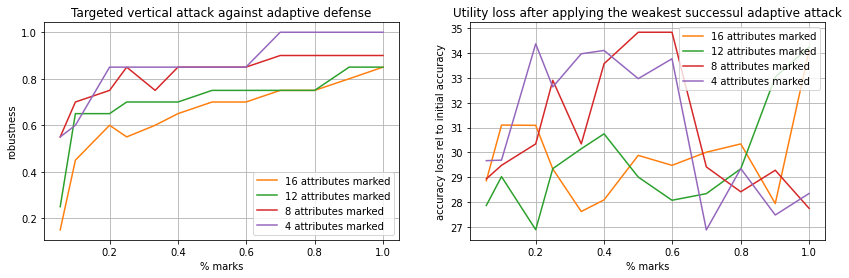

In [179]:
#plt.plot(horizontal_x, utility_line_2, color='#ffe3e3', label='attacker loses >1% of acc')
#plt.fill_between(horizontal_x, [0.81 for i in horizontal_x], utility_line_2, color='#ffe3e3')

#plt.plot(horizontal_x, utility_line, color='#ffabab', label='attacker loses >2% of acc')#
#plt.fill_between(horizontal_x, [0.81 for i in horizontal_x], utility_line, color='#ffabab')
fig, axs = plt.subplots(1,2, figsize=(14,4))

# ROBUSTNESS PLOT
axs[0].plot(x, y_16, label='16 attributes marked', color=colors[1])
axs[0].plot(x, y_12, label='12 attributes marked',color=colors[2])
axs[0].plot(x, y_8, label='8 attributes marked',color=colors[3])
axs[0].plot(x, y_4, label='4 attributes marked',color=colors[4])

axs[0].set_xlabel('% marks')
axs[0].set_ylabel('robustness')
axs[0].legend()
axs[0].grid()
axs[0].set_title('Targeted vertical attack against adaptive defense')

axs[1].plot(x, [i*100 for i in utility_loss[16].values()], label='16 attributes marked',color=colors[1])
axs[1].plot(x, [i*100 for i in utility_loss[12].values()], label='12 attributes marked',color=colors[2])
axs[1].plot(x, [i*100 for i in utility_loss[8].values()], label='8 attributes marked',color=colors[3])
axs[1].plot(x, [i*100 for i in utility_loss[4].values()], label='4 attributes marked',color=colors[4])

axs[1].set_xlabel('% marks')
axs[1].set_ylabel('accuracy loss rel to initial accuracy')
axs[1].set_title('Utility loss after applying the weakest successul adaptive attack')
axs[1].legend()
axs[1].grid()

In [35]:
#todo: delete
x = 1.0 / np.array(list(original[4].keys())) # percentage of marked rows
with open('utility_loss.pkl', 'rb') as infile:
    utility_loss = pickle.load(infile)

In [36]:
x = [i for i in utility_loss[4]]

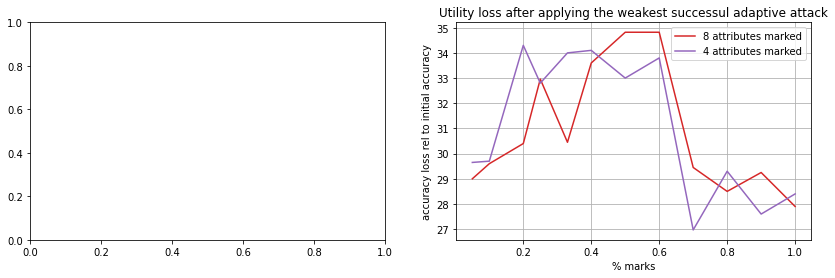

In [38]:
# todo: delete

#plt.plot(horizontal_x, utility_line_2, color='#ffe3e3', label='attacker loses >1% of acc')
#plt.fill_between(horizontal_x, [0.81 for i in horizontal_x], utility_line_2, color='#ffe3e3')

#plt.plot(horizontal_x, utility_line, color='#ffabab', label='attacker loses >2% of acc')#
#plt.fill_between(horizontal_x, [0.81 for i in horizontal_x], utility_line, color='#ffabab')
fig, axs = plt.subplots(1,2, figsize=(14,4))

# ROBUSTNESS PLOT
#axs[0].plot(x, y_16, label='16 attributes marked', color=colors[1])
#axs[0].plot(x, y_12, label='12 attributes marked',color=colors[2])
#axs[0].plot(x, y_8, label='8 attributes marked',color=colors[3])
#axs[0].plot(x, y_4, label='4 attributes marked',color=colors[4])

#axs[0].set_xlabel('% marks')
#axs[0].set_ylabel('robustness')
#axs[0].legend()
#axs[0].grid()
#axs[0].set_title('Targeted vertical attack against adaptive defense')

#axs[1].plot(x, [i*100 for i in utility_loss[16].values()], label='16 attributes marked',color=colors[1])
#axs[1].plot(x, [i*100 for i in utility_loss[12].values()], label='12 attributes marked',color=colors[2])
axs[1].plot(x, [i for i in utility_loss[8].values()], label='8 attributes marked',color=colors[3])
axs[1].plot(x, [i for i in utility_loss[4].values()], label='4 attributes marked',color=colors[4])

axs[1].set_xlabel('% marks')
axs[1].set_ylabel('accuracy loss rel to initial accuracy')
axs[1].set_title('Utility loss after applying the weakest successul adaptive attack')
axs[1].legend()
axs[1].grid()

In [73]:
original

{16: {1: [array([0.775, 0.755, 0.755, 0.765, 0.75 ]),
   array([0.775, 0.755, 0.755, 0.765, 0.75 ]),
   array([0.775, 0.755, 0.755, 0.765, 0.75 ]),
   array([0.775, 0.755, 0.755, 0.765, 0.75 ]),
   array([0.775, 0.755, 0.755, 0.765, 0.75 ])],
  1.11: [array([0.775, 0.755, 0.755, 0.765, 0.75 ]),
   array([0.775, 0.755, 0.755, 0.765, 0.75 ]),
   array([0.775, 0.755, 0.755, 0.765, 0.75 ]),
   array([0.775, 0.755, 0.755, 0.765, 0.75 ]),
   array([0.775, 0.755, 0.755, 0.765, 0.75 ])],
  1.25: [array([0.775, 0.755, 0.755, 0.765, 0.75 ]),
   array([0.775, 0.755, 0.755, 0.765, 0.75 ]),
   array([0.775, 0.755, 0.755, 0.765, 0.75 ]),
   array([0.775, 0.755, 0.755, 0.765, 0.75 ]),
   array([0.775, 0.755, 0.755, 0.765, 0.75 ])],
  1.43: [array([0.775, 0.755, 0.755, 0.765, 0.75 ]),
   array([0.775, 0.755, 0.755, 0.765, 0.75 ]),
   array([0.775, 0.755, 0.755, 0.765, 0.75 ]),
   array([0.775, 0.755, 0.755, 0.765, 0.75 ]),
   array([0.775, 0.755, 0.755, 0.765, 0.75 ])],
  1.67: [array([0.775, 0.755, 0

In [74]:
results[16]

{1: [array([0.53, 0.5 , 0.49, 0.52, 0.48]),
  array([0.53, 0.5 , 0.49, 0.52, 0.48]),
  array([0.53, 0.5 , 0.49, 0.52, 0.48]),
  array([0.53, 0.5 , 0.49, 0.52, 0.48]),
  array([0.53, 0.5 , 0.49, 0.52, 0.48])],
 1.11: [array([0.555, 0.525, 0.545, 0.535, 0.51 ]),
  array([0.555, 0.525, 0.545, 0.535, 0.51 ]),
  array([0.555, 0.525, 0.545, 0.535, 0.51 ]),
  array([0.555, 0.525, 0.545, 0.535, 0.51 ]),
  array([0.555, 0.525, 0.545, 0.535, 0.51 ])],
 1.25: [array([0.565, 0.52 , 0.535, 0.52 , 0.525]),
  array([0.565, 0.52 , 0.535, 0.52 , 0.525]),
  array([0.565, 0.52 , 0.535, 0.52 , 0.525]),
  array([0.565, 0.52 , 0.535, 0.52 , 0.525]),
  array([0.565, 0.52 , 0.535, 0.52 , 0.525])],
 1.43: [array([0.565, 0.52 , 0.535, 0.52 , 0.525]),
  array([0.565, 0.52 , 0.535, 0.52 , 0.525]),
  array([0.565, 0.52 , 0.535, 0.52 , 0.525]),
  array([0.565, 0.52 , 0.535, 0.52 , 0.525]),
  array([0.565, 0.52 , 0.535, 0.52 , 0.525])],
 1.67: [array([0.57 , 0.53 , 0.545, 0.515, 0.505]),
  array([0.57 , 0.53 , 0.545

In [94]:
# original to compare to 0.768
util_loss =dict()

In [99]:
util_loss[16] = dict()
for gamma in original[16]:
    util_loss[16][gamma] = np.mean([(0.768-original[16][gamma][i])/0.768 for i in range(5)])

In [100]:
util_loss

{4: {1: 0.010416666666666676,
  1.11: 0.010416666666666676,
  1.25: 0.010416666666666676,
  1.43: 0.010416666666666676,
  1.67: 0.010416666666666676,
  2: 0.010416666666666676,
  2.5: 0.010416666666666676,
  3: 0.010416666666666676,
  4: 0.010416666666666676,
  5: 0.010416666666666676,
  10: 0.010416666666666676,
  18: 0.010416666666666676},
 8: {1: 0.010416666666666676,
  1.11: 0.010416666666666676,
  1.25: 0.010416666666666676,
  1.43: 0.010416666666666676,
  1.67: 0.010416666666666676,
  2: 0.010416666666666676,
  2.5: 0.010416666666666676,
  3: 0.010416666666666676,
  4: 0.010416666666666676,
  5: 0.010416666666666676,
  10: 0.010416666666666676,
  18: 0.010416666666666676},
 12: {1: 0.010416666666666676,
  1.11: 0.010416666666666676,
  1.25: 0.010416666666666676,
  1.43: 0.010416666666666676,
  1.67: 0.010416666666666676,
  2: 0.010416666666666676,
  2.5: 0.010416666666666676,
  3: 0.010416666666666676,
  4: 0.010416666666666676,
  5: 0.010416666666666676,
  10: 0.0104166666666666

In [102]:
fp_attr = dict()

In [107]:
fp_util = dict()

In [127]:
# original data
data = GermanCredit()
X = data.preprocessed().drop('target', axis=1)
y = data.preprocessed()['target']
X.columns

Index(['checking_account', 'duration', 'credit_hist', 'purpose',
       'credit_amount', 'savings', 'employment_since', 'installment_rate',
       'sex_status', 'debtors', 'residence_since', 'property', 'age',
       'installment_other', 'housing', 'existing_credits', 'job',
       'liable_people', 'tel', 'foreign'],
      dtype='object')

In [159]:
# find strength that removes the fingerprint - test run
gammae = gammae = [1,1.11, 1.25, 1.43, 1.67, 2,2.5, 3, 4, 5, 10, 18]  
    #gammae = [1.11, 1.25, 1.43, 1.67, 2.5]
fpattr=4
fp_util[fpattr] = dict()
for gamma in gammae:
    scheme = Universal(gamma=gamma, xi=xi, fingerprint_bit_length=fplen, number_of_recipients=100)
    fingerprinted_data = scheme.insertion(data, recipient_id=uid, secret_key=0, exclude=exclude[fpattr], 
                                  target_attribute='target')
    fp_data = GermanCredit().preprocessed(fingerprinted_data.dataframe)
    #split
    X_fp = fp_data.drop('target', axis=1)
    y_fp = fp_data['target']
    # original accuracy
    model = GradientBoostingClassifier(random_state=9)
    fp_util[fpattr][gamma] =fp_cross_val_score(model, X, y,X_fp,y_fp)['test_score']


Start insertion algorithm...
	gamma: 1
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 0

Generated fingerprint for recipient 1: 01011111
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~100.0%
	single fingerprint bit embedded 125 times
Time: <1 sec.
Start insertion algorithm...
	gamma: 1.11
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 0

Generated fingerprint for recipient 1: 01011111
	Inserting a fingerprint into columns: Index(['checking_account', 'duration', 'purpose', 'property'], dtype='object')
Fingerprint inserted.
	marked tuples: ~89.5%
	single fingerprint bit embedded 111 times
Time: <1 sec.
Start insertion algorithm...
	gamma: 1.25
	fingerprint length: 8
	xi: 1
	# recipients: 100

	(secret key -- for evaluation purposes): 0

Generated fingerprint for recipient 1: 01011111
	Insert

In [142]:
fp_util

{4: {1: array([0.75 , 0.79 , 0.755, 0.76 , 0.76 ]),
  1.11: array([0.745, 0.77 , 0.74 , 0.77 , 0.76 ]),
  1.25: array([0.79 , 0.765, 0.755, 0.775, 0.745]),
  1.43: array([0.775, 0.785, 0.775, 0.765, 0.735]),
  1.67: array([0.76 , 0.775, 0.76 , 0.775, 0.745]),
  2: array([0.785, 0.775, 0.76 , 0.765, 0.755]),
  2.5: array([0.765, 0.775, 0.74 , 0.765, 0.76 ]),
  3: array([0.76 , 0.775, 0.755, 0.765, 0.745]),
  4: array([0.76 , 0.775, 0.755, 0.76 , 0.755]),
  5: array([0.745, 0.775, 0.77 , 0.77 , 0.755]),
  10: array([0.745, 0.77 , 0.76 , 0.775, 0.745]),
  18: array([0.765, 0.77 , 0.765, 0.76 , 0.77 ])},
 8: {1: array([0.75 , 0.79 , 0.755, 0.76 , 0.76 ]),
  1.11: array([0.745, 0.77 , 0.74 , 0.77 , 0.76 ]),
  1.25: array([0.79 , 0.765, 0.755, 0.775, 0.745]),
  1.43: array([0.775, 0.785, 0.775, 0.765, 0.735]),
  1.67: array([0.76 , 0.775, 0.76 , 0.775, 0.745]),
  2: array([0.785, 0.775, 0.76 , 0.765, 0.755]),
  2.5: array([0.765, 0.775, 0.74 , 0.765, 0.76 ]),
  3: array([0.76 , 0.775, 0.755,

In [160]:
fp_util_rel = dict()

In [174]:
fp_util_rel[4] = dict()
for gamma in fp_util[4]:
    fp_util_rel[4][gamma] = np.mean([abs((0.768-fp_util[4][gamma][i]))/0.768 for i in range(5)])

In [165]:
x = 1.0 / np.array(list(fp_util_rel[16].keys())) # percentage of marked rows

Text(0.5, 1.0, 'Gradient Boosting')

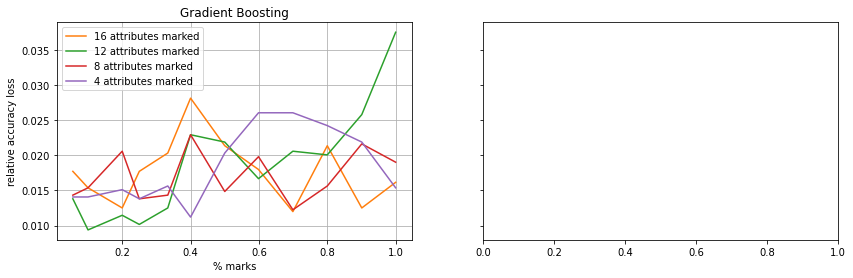

In [178]:
# UTILITY PLOT
fig, axs = plt.subplots(1,2, figsize=(14,4), sharey=True)

# RELATIVE LOSS
axs[0].plot(x, fp_util_rel[16].values(), label='16 attributes marked', color=colors[1])
axs[0].plot(x, fp_util_rel[12].values(), label='12 attributes marked', color=colors[2])
axs[0].plot(x, fp_util_rel[8].values(), label='8 attributes marked', color=colors[3])
axs[0].plot(x, fp_util_rel[4].values(), label='4 attributes marked', color=colors[4])

# ABSOLUTE ACC
#axs[0].plot(x, utility_fp_gb_e80_avg_y, label='20 attributes marked')
#axs[0].plot(x, utility_fp_gb_fpattr16_e80_avg_y, label='16 attributes marked') 
#axs[0].plot(x, utility_fp_gb_fpattr12_e80_avg_y, label='12 attributes marked')
#axs[0].plot(x, utility_fp_gb_fpattr8_e80_avg_y, label='8 attributes marked')
#axs[0].plot(x, utility_fp_gb_fpattr4_e80_avg_y, label='4 attributes marked')

#axs[0].plot(x, gb_baseline_y, label='GB baseline')

axs[0].set_xlabel('% marks')
axs[0].set_ylabel('relative accuracy loss')
axs[0].legend()
axs[0].grid()
axs[0].set_title('Gradient Boosting')
